You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from sklearn import metrics

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [5]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [6]:
#look at data type, check null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [7]:
df = df.drop('ctz', axis=1)

In [8]:
df.nunique()

10k           2766
name         31915
division      6979
25k           6570
gender           2
age             64
official     11030
bib          31984
genderdiv    17575
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

In [9]:
#drop the things that are unique to each runner. 
df = df.drop(['name', 'bib'], axis=1)
df.gender = df.gender.map(lambda x: 0 if x is 'F' else 1)

In [10]:
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [13]:
splits = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for dist in splits:
    df[dist] = pd.to_numeric(df[dist], errors='coerce')
    df[dist] = df[dist].map(lambda x: df[dist].mean() if x is '-' else float(x))

In [14]:
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


### Look at possible features to cluster on

In [16]:
df.country.value_counts().head(30)

USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
CHI       29
ISL       28
FIN       28
BEL       27
SIN       23
AUT       22
NOR       21
RSA       19
VEN       19
BER       18
Name: country, dtype: int64

In [19]:
df.state.value_counts().head(30)

MA    7587
CA    2326
NY    1553
ON    1052
PA    1001
TX     992
IL     916
OH     760
FL     750
VA     713
MI     695
NC     618
WA     596
CO     578
NJ     569
MN     556
MD     527
NH     526
CT     521
GA     443
WI     433
UT     431
QC     419
OR     406
AZ     318
IN     291
TN     261
MO     256
ME     250
RI     233
Name: state, dtype: int64

In [20]:
df.city.value_counts().head(30)

Boston           1034
New York          498
Chicago           313
Cambridge         311
Toronto           240
Somerville        240
Brookline         222
Washington        212
Newton            201
Austin            192
San Francisco     192
Portland          191
Arlington         184
San Diego         182
Brighton          151
Seattle           149
Charlestown       148
Houston           138
London            135
Quincy            134
Medford           132
Brooklyn          131
Ottawa            130
South Boston      130
Atlanta           122
Denver            118
Dorchester        117
Calgary           109
Cincinnati        106
Wellesley         105
Name: city, dtype: int64

In [25]:
X = df.drop(['country', 'state', 'city'], axis = 1)

In [28]:
#normalize
X_norm = normalize(X.dropna(axis=0, how='any'))
print(len(X_norm))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

31649


In [40]:
#create 4 sets to cross val
#Divide into two sets.
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(X_norm, X_pca, test_size=0.5, random_state=85)

#since we have an odd number, need to take one away from xhalf2
Xhalf2 = Xhalf2[:15824][:]
print(len(Xhalf1))
print(len(Xhalf2))

15824
15824


In [42]:
#Dividing into four sets
X1, X2, X_pca1, X_pca2 = train_test_split(Xhalf1, X_pca_1, test_size=0.5, random_state=85)
X3, X4, X_pca3, X_pca4 = train_test_split(Xhalf2, X_pca_1, test_size=0.5, random_state=85)

#Checking the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7912 7912


## K-Means

In [43]:
ypred = pd.DataFrame()
score = pd.DataFrame(columns=['cluster_pred','sil_score'])

#Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
       
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=nclust, random_state=85)
        pred = kmeans.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore}, ignore_index=True)

In [44]:
# Sorting sihoilette scores
score.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,sil_score,silhouette_score
10,clust4_sample2,NaN,0.497351
2,clust4_sample0,NaN,0.496659
14,clust4_sample3,NaN,0.496249
6,clust4_sample1,NaN,0.490639
9,clust3_sample2,NaN,0.480366
1,clust3_sample0,NaN,0.479504
13,clust3_sample3,NaN,0.479365
5,clust3_sample1,NaN,0.472563
4,clust2_sample1,NaN,0.462885
11,clust5_sample2,NaN,0.455593


A four-cluster model has the highest sihlouette score

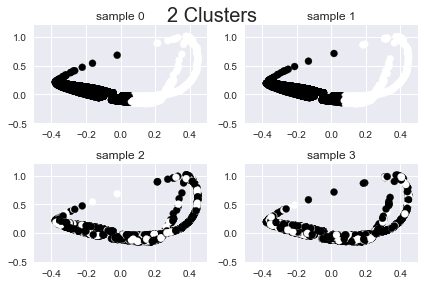

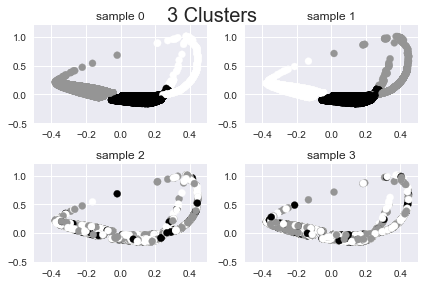

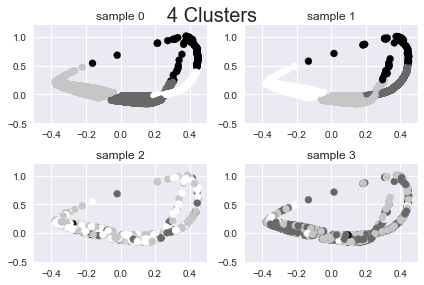

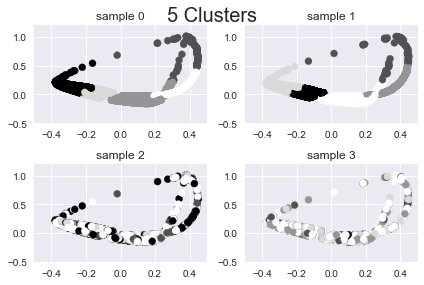

In [45]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Two clusters looks pretty good! 

## Mean-shift

In [46]:
# Initialize new data frames
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['cluster_pred','mean_shift', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        # Ensuring all sets are the same lenght
        data = data[:4013][:]
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms['clust' + str(cntrs) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'cluster_pred':'clust' + str(cntrs) + '_sample' + str(counter), 
                              'silhouette_score':sscore, 'quantile':n}, ignore_index=True)

In [47]:
score_ms.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,mean_shift,quantile,silhouette_score
13,clust3_sample3,NaN,0.2,0.530331
6,clust5_sample1,NaN,0.3,0.521656
10,clust4_sample2,NaN,0.3,0.515906
7,clust5_sample1,NaN,0.4,0.505131
5,clust5_sample1,NaN,0.2,0.503255
14,clust3_sample3,NaN,0.3,0.499871
15,clust4_sample3,NaN,0.4,0.492727
2,clust3_sample0,NaN,0.3,0.481546
3,clust4_sample0,NaN,0.4,0.479822
8,clust10_sample2,NaN,0.1,0.474754


## Spectral Clustering

In [49]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [50]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
10,clust4_sample2,0.495618
14,clust4_sample3,0.494526
2,clust4_sample0,0.494254
6,clust4_sample1,0.487666
9,clust3_sample2,0.478114
13,clust3_sample3,0.476876
1,clust3_sample0,0.476786
5,clust3_sample1,0.469284
4,clust2_sample1,0.446452
8,clust2_sample2,0.441454


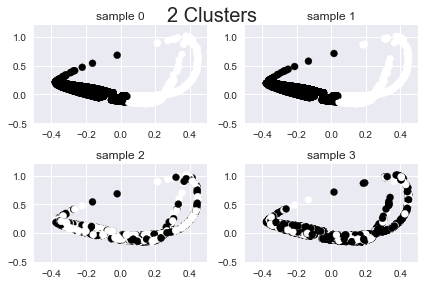

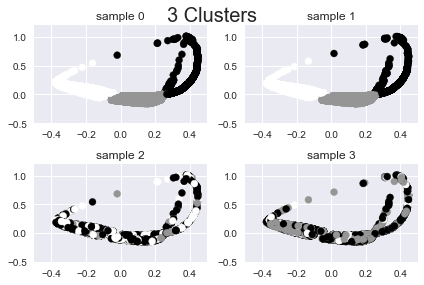

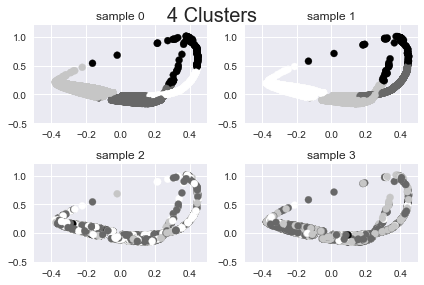

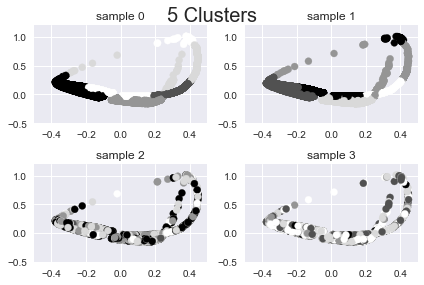

In [51]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_sc['pca_f1_sample{}'.format(i)]
        y_sub = ypred_sc['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_sc['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

## Affinity

In [52]:
# Initialize data frames
ypred = pd.DataFrame()
score_af = pd.DataFrame(columns=['cluster_pred','AF'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Ensuring all sets are the same lenght
    data = data[:4013][:]
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    #pred = af.fit_predict(data)
    #ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    # Calculating silhouette scores for the data and adding that to the shilouette score
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'cluster_pred':'clust' + str(n_clusters_) + '_sample' + str(counter), 
                              'AF':sscore_af}, ignore_index=True)

In [53]:
score_af.sort_values(by='AF', ascending=False)

#these values are unreasonable

,cluster_pred,AF
2,clust1671_sample2,0.235772
1,clust2007_sample1,0.158340
0,clust2536_sample0,0.095977
3,clust3436_sample3,0.044966


## Conclusion

4-cluster solution seems to return the highest Silhouette scores.

In [54]:
# Calculate predicted values.#l 
y_pred = KMeans(n_clusters=4, random_state=85).fit_predict(X_norm)

In [55]:
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']

# Add the outcome back onto X
combined = X.join(df_y, how='inner')
combined.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,Cluster
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,2
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,2
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,2
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,2
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,2


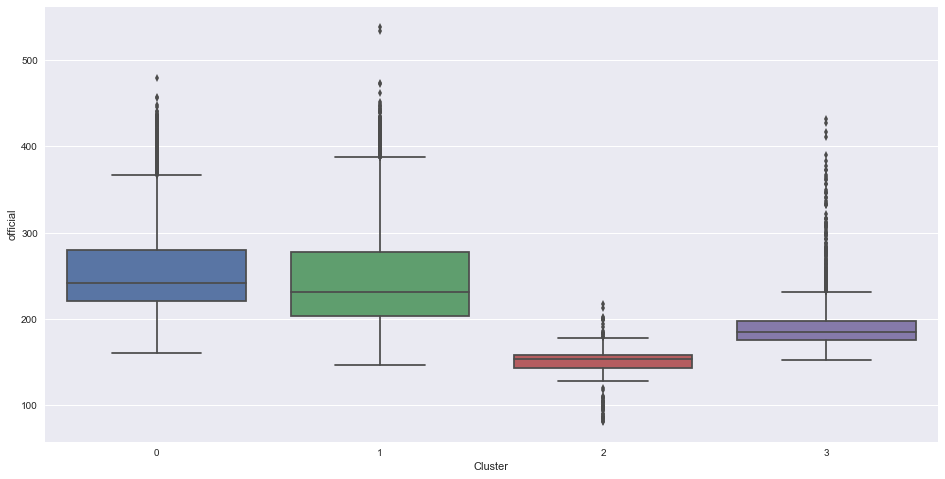

In [56]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster',y='official',data=combined)

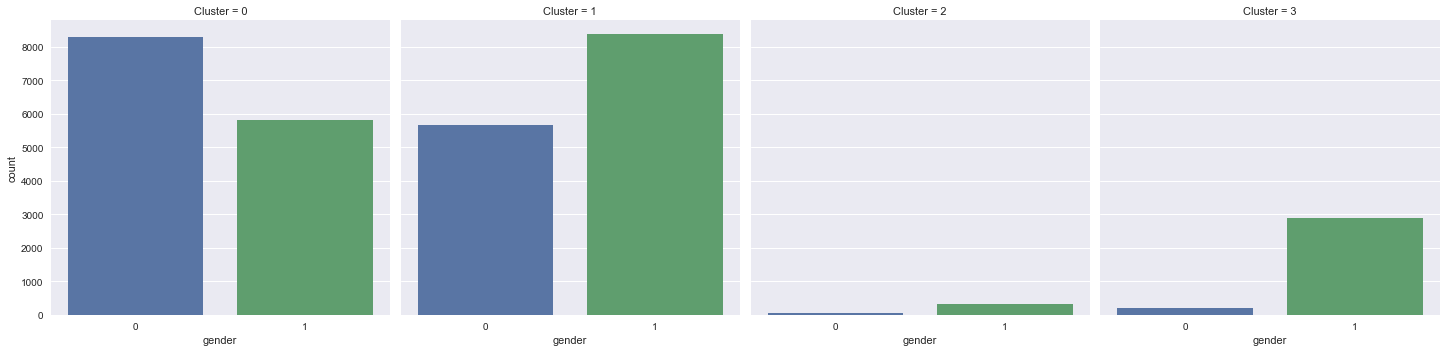

In [57]:
sns.factorplot(x='gender', col='Cluster', kind="count", data=combined, size=5)

In [58]:
cluster0 = combined[combined['Cluster']==0]
cluster1 = combined[combined['Cluster']==1]
cluster2 = combined[combined['Cluster']==2]
cluster3 = combined[combined['Cluster']==3]

In [59]:
cluster0['gender'].value_counts()

0    8300
1    5823
Name: gender, dtype: int64

In [60]:
cluster1['gender'].value_counts()

1    8371
0    5680
Name: gender, dtype: int64

In [61]:
cluster2['gender'].value_counts()

1    326
0     44
Name: gender, dtype: int64

In [62]:
cluster3['gender'].value_counts()

1    2892
0     213
Name: gender, dtype: int64